## Trees and Phylogenetics
In this week's notebook we will explore principals of phylogenetics and tree-like thinking using a combination of data analysis, empowered via biopython, and first principals coding work. 

### A simple tree representation
One very simple and popular way to represent a tree is with what is known as a [Newick](https://en.wikipedia.org/wiki/Newick_format) format. A Newick tree uses a series of parentheses to describe the relations of taxa up a tree. To start I've included a toy tree example named `tree.newick` in the data directory. That file is written in the  which  In this case I've used the tree

`(((1,2),(3,4)),(5,6));`

Represented visually this simple tree looks like the following 

<img src=imgs/tree.png>

Let's start by constructing trees using the UPGMA and Neighbor Joining algorithms that I introduced in class and then we will move to more industrial strength implementations using biopython.

In [1]:
# a upgma implementation
import numpy as np
from matplotlib import pyplot as plt

def coal_label(str1, str2):
    """
    utility function to build up newick tree string
    """
    new = f"({str1},{str2})"
    return(new)

def find_min_idx(tmpMat):
    """
    returns index of smallest cell assuming symmetric
    matrix with distances on off-diagonal elements
    """
    min = 1e6
    min_i = min_j = -666
    for i in range(tmpMat.shape[0]):
        j = 0
        while j < i:
            if tmpMat[i,j] < min:
                min_i = i
                min_j = j
                min = tmpMat[i,j]
            j+=1
        
    return(min_i,min_j)


def upgma(mat, label_list):
    """
    returns a newick string representation of the tree
    mat is the distanace matrix
    label_list is a list of taxon names
    """
    labels = label_list.copy()

    while len(labels) > 1:
        # Find index of smallest dist
        min_i, min_j = find_min_idx(mat)
        # Deal with the tree string, merge labels
        labels.append(coal_label(labels[min_j],labels[min_i]))
        # Delete orig labels
        del labels[min_i]
        del labels[min_j]
        # Create a new row and column, so new clade appends to end
        mat = np.insert(mat, mat.shape[0], values=float(0), axis=0)
        mat = np.insert(mat, mat.shape[1], values=float(0), axis=1)

        # Fill new row with average distances
        for i in np.arange (0, mat.shape[1] - 1):
                mat[-1][i]=mat[i][-1] = (mat[i][min_j] + mat[i][min_i])/2
        
        # Delete the old rows / columns we don't need        
        mat = np.delete(mat, min_j, 0)
        mat = np.delete(mat, min_j, 1)
        mat = np.delete(mat, min_i-1, 0)
        mat = np.delete(mat, min_i-1, 1)
        
    return(labels[0])


labels = ["dog","cat","rat","mouse","cow"]

aMat = np.array([[0, 17, 21, 31, 23],[17,0,30,34,21],
                [21,30,0,28,39],[31,34,28,0,43],
                [23,21,39,43,0]],dtype='float64')
print("distance matrix:")
print(aMat)
print("------")
upgma(aMat, labels)


distance matrix:
[[ 0. 17. 21. 31. 23.]
 [17.  0. 30. 34. 21.]
 [21. 30.  0. 28. 39.]
 [31. 34. 28.  0. 43.]
 [23. 21. 39. 43.  0.]]
------


'((cow,(dog,cat)),(rat,mouse))'

In [2]:
def NJ_q_matrix(mat):
    """
    Returns Q matrix calculated from distance matrix
    according to Neighbor-Joining algorithm of
    Saitou and Nei 
    """
    n = mat.shape[0]
    q = np.zeros(mat.shape)
    sums = np.sum(mat, axis=1)
    for i in range(n):
        for j in range(n):
            if i != j:
                q[i,j] = (n - 2) * mat[i,j] - sums[i] - sums [j]
    return(q)
  
def NJ(mat, label_list):
    """
    returns a newick string representation of the tree
    mat is the distanace matrix
    label_list is a list of taxon names
    """
    labels = label_list.copy()

    while len(labels) > 1:
        # Calc Q matrix of net distances
        q = NJ_q_matrix(mat)
        # Find index of smallest dist
        min_i, min_j = find_min_idx(q)
        # Deal with the tree string, merge labels
        labels.append(coal_label(labels[min_j],labels[min_i]))
        # Delete orig labels
        del labels[min_i]
        del labels[min_j]
        # Create a new row and column, so new clade appends to end
        mat = np.insert(mat, mat.shape[0], values=float(0), axis=0)
        mat = np.insert(mat, mat.shape[1], values=float(0), axis=1)

        # Fill new row with new distances
        for i in np.arange (0, mat.shape[1] - 1):
                mat[-1][i]= mat[i][-1] = (mat[i][min_j] + mat[i][min_i] - mat[min_j][min_i])/2
        
        # Delete the old rows / columns we don't need        
        mat = np.delete(mat, min_j, 0)
        mat = np.delete(mat, min_j, 1)
        mat = np.delete(mat, min_i-1, 0)
        mat = np.delete(mat, min_i-1, 1)
        
    return(labels[0])

In [3]:
labels = ["1","2","3","4","5"]
aMat = np.array([[0, 5, 9, 9, 8],[5,0,10,10,9],
                [9,10,0,8,7],[9,10,8,0,3],
                [8,9,7,3,0]],dtype='float64')
nj_tree = NJ(aMat, labels)
print(nj_tree)


((4,5),(3,(1,2)))


# Biopython
bipython gives us lots of basic functionality for dealing with trees through the `Bio.Phylo` module. The full documentation for this module can be found [here](http://biopython.org/DIST/docs/tutorial/Tutorial.html#htoc200).Functionality includes reading/writing/converting trees, tree visualization tools, and interfaces to external phylogenetics packages such as phylip and PAML



We will start by reading in the tree and using the native print() to summarize it

In [4]:
from Bio import Phylo

tree = Phylo.read("data/tree.newick", "newick")
print(tree)

Tree(rooted=False, weight=1.0)
    Clade()
        Clade()
            Clade()
                Clade(name='1')
                Clade(name='2')
            Clade()
                Clade(name='3')
                Clade(name='4')
        Clade()
            Clade(name='5')
            Clade(name='6')


Here you will not that a `Tree` object is returned that represents the hierarchical relationships in `Clade` objects. We won't deal with those directly today, but know that they are their and something you can manipulate. 

Next let's draw the tree. This is quite easy to do

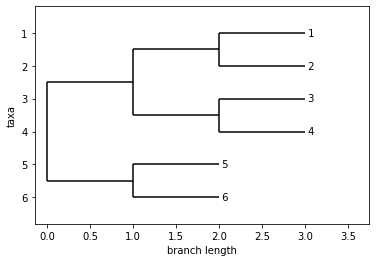

In [5]:
Phylo.draw(tree)

We can of course do things like add or remove labels and add colors to different parts of the tree. Not that I able to find particular clades by asking for the common ancestor of two taxa

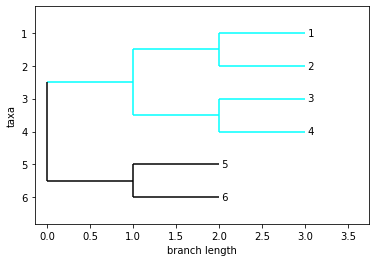

In [6]:
mrca = tree.common_ancestor({"name": "1"}, {"name": "3"})
mrca.color="cyan"
Phylo.draw(tree)

we can even draw our NJ tree from above using a quick call to the system to write the string out

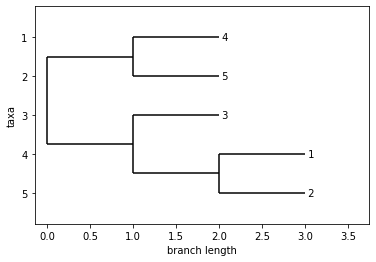

In [7]:
from io import StringIO
tree = Phylo.read(StringIO(NJ(aMat, labels)), "newick")
Phylo.draw(tree)

# Making trees from actual sequence data
biopython has decent algorithms for creating many sorts of trees from sequence data including the NJ and UPGMA trees that we have looked at above. It does this through it's so-called constructor methods. We will play with a simple example first

## a distance tree of lysozyme
A classic molecular phylogenetics dataset that has been circulating for years is the primate lysozyme alignment. This is a simple coding sequence alignment of a single enzyme from a bunch of primates. I've included it for you here `data/lysozymeSmall.fasta`.

Let's open then alignment using biopython and create and display a distance tree

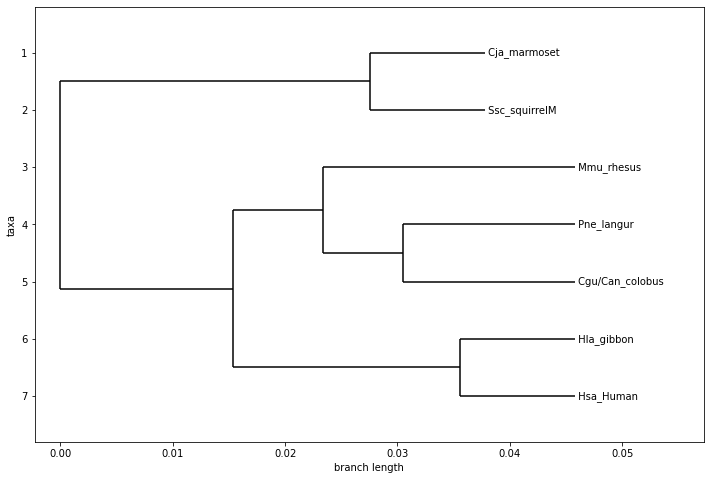

[<AxesSubplot:xlabel='branch length', ylabel='taxa'>]

In [8]:
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor
from Bio.Phylo.TreeConstruction import DistanceCalculator
from Bio import AlignIO
from matplotlib import pyplot as plt

lyso = AlignIO.read("data/lysozymeSmall.fasta","fasta")
fig,ax = plt.subplots(figsize=[12,8])

calculator = DistanceCalculator('identity')
constructor = DistanceTreeConstructor(calculator, 'upgma')
tree = constructor.build_tree(lyso)
#hate the internal name labels
for n in tree.get_nonterminals():
    n.name=""

Phylo.draw(tree,axes=ax)
fig.axes

pretty neat huh? we can of course also get out the distance matrix that was calculated easily enough

In [9]:
dm = calculator.get_distance(lyso)
print(dm)

Hsa_Human	0
Hla_gibbon	0.02051282051282055	0
Cgu/Can_colobus	0.0692307692307692	0.0692307692307692	0
Pne_langur	0.06666666666666665	0.07692307692307687	0.03076923076923077	0
Mmu_rhesus	0.04871794871794877	0.05384615384615388	0.043589743589743546	0.0461538461538461	0
Ssc_squirrelM	0.07435897435897432	0.07435897435897432	0.0871794871794872	0.10256410256410253	0.06666666666666665	0
Cja_marmoset	0.07435897435897432	0.0692307692307692	0.08205128205128209	0.09743589743589742	0.06153846153846154	0.02051282051282055	0
	Hsa_Human	Hla_gibbon	Cgu/Can_colobus	Pne_langur	Mmu_rhesus	Ssc_squirrelM	Cja_marmoset


## Distance trees for our spike protein alignments


I've gone ahead and created a multiple alignment file of Spike gene alignments from the `covid_small.fasta` file. This new file can be found at `data/spike_align.fasta`. 

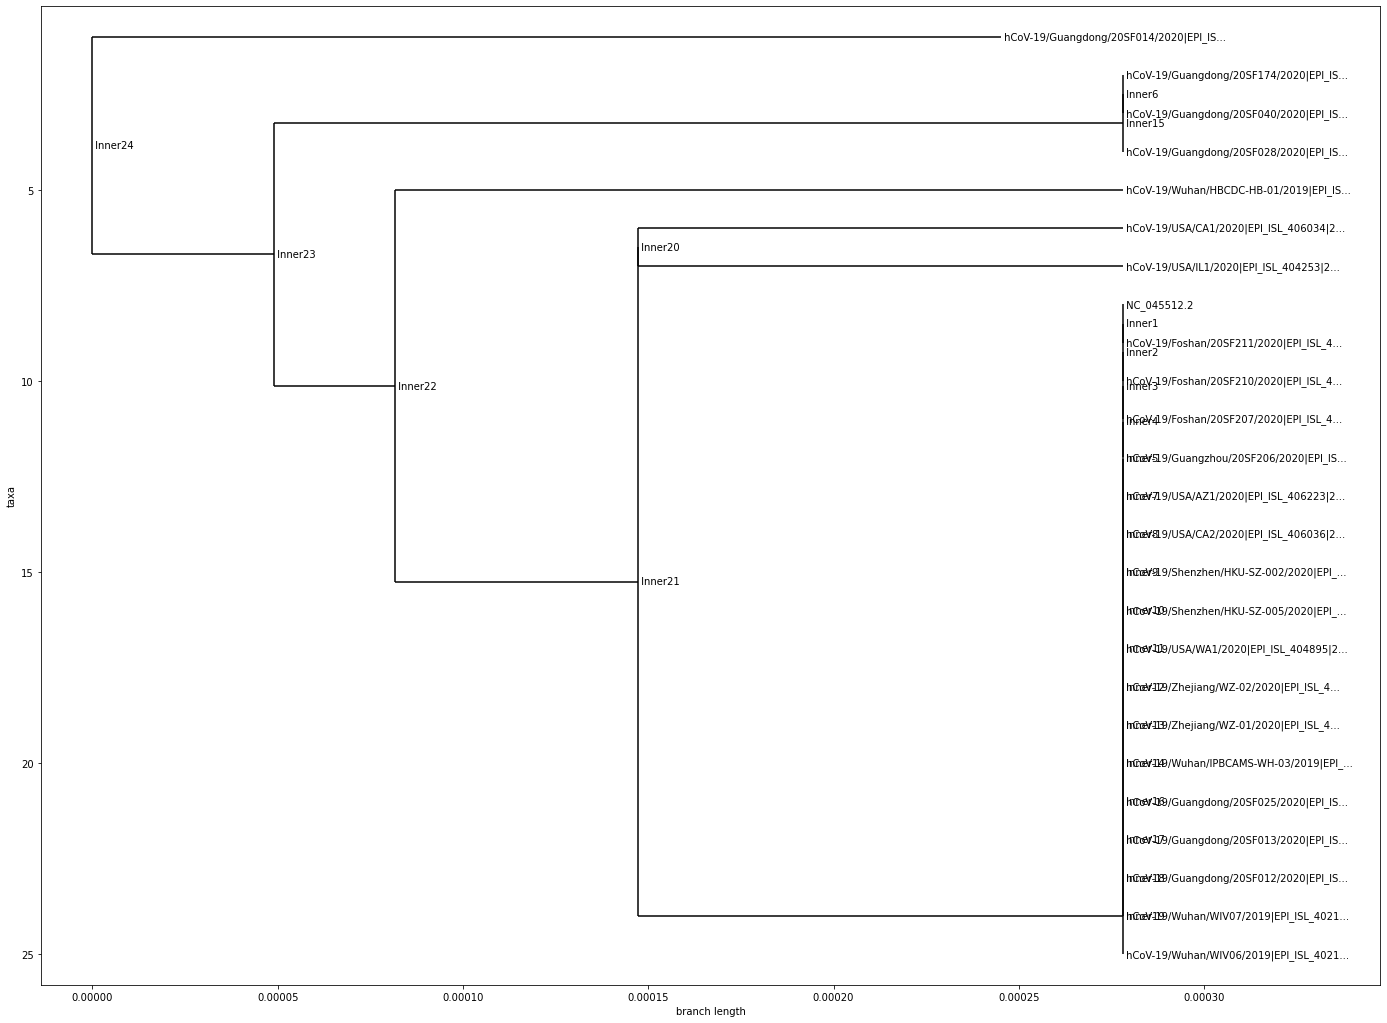

[<AxesSubplot:xlabel='branch length', ylabel='taxa'>]

In [10]:
from Bio.Phylo.TreeConstruction import DistanceCalculator
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor
from Bio.Align import MultipleSeqAlignment
from matplotlib import pyplot as plt


spike_align = AlignIO.read("data/spike_align.fasta","fasta")

fig,ax = plt.subplots(figsize=[24,18])
constructor = DistanceTreeConstructor(calculator, 'upgma')
tree = constructor.build_tree(spike_align)
Phylo.draw(tree,axes=ax)
fig.axes



# Maximum Likelihood
The Maximum Likelihood principle says that the most probable explanation for some dataset, given a model, is the best explanation. While this might strike you as a trivially obvious point of view, mathematically it is not necessarily so. Statistical estimation using Maximum Likelihood (ML) was popularized by R. A. Fisher (of population genetics fame) in the early part of the 20th Century. ML estimation has been broadly applied across the sciences as a technology for learning about natural processes, but for our purposes we will particularly highlight its utility in estimating phylogenetic trees. 

The basic setup is that I want to write down a function that describes the probability of my data given the parameters of my model-- what is known in the business as the **Likelihood Function**. Abstractly then, given some dataset $X$ and some set of parameters associated with my model, call them $\theta$, we seek to write down the likelihood of $X$ given $\theta$ or

\begin{equation*}
L(\theta) = Prob(X | \theta)
\end{equation*}

## Flipping Coins
ML estimation is totally general, so consider some dataset $X$ that consists of multiple, independent observations from some process. $X$ could for instance be the number of times you flipped heads in a set of n coin flips. The process here, coin flipping, is associated with a parameter, the probability of getting heads. Random variables that follow this sort of process (a heads or tails outcome repeated many times) are called binomial random variables and their probabilities come from the so-called Binomial Distribution. So without further ado, the probability that I flip a coin $n$ times and end up with $X=k$ heads is

\begin{equation*}
P(X=k| n, p) = \binom{n}{k} p^k (1-p)^{n-k}
\end{equation*}

where $p$ is the probability that any one coin flip will come up heads. Let's write the code to calculate such probabilities, it's pretty straightforward


a slicker, and more general way to have done this would have been to try to find the maximum of this function using some mathematics. In particular there are a huge number of ways to optimize functions to find there minimum or maximum value, and many of these are already available to us through the python tools I've been introducing in class. We can dip in to the `scipy` library for what we need here

In [11]:
import numpy as np
from matplotlib import pyplot as plt

# define our probability function in this case
# the binomial probabilty mass function
def binomial_prob(heads, n, p):
    """
    returns probability of heads # of successes
    in n flips of a coin with probability(heads) = p
    """
    b_coef = np.math.factorial(n) / (np.math.factorial(n-heads) *\
                                     np.math.factorial(heads))
    return(b_coef * p**heads * (1-p)**(n-heads))

now let's use this code to plot what the probability of different numbers of heads would be if I flipped a _fair_ ($p=0.5$) coin $n=10$ times

Text(0, 0.5, 'probability')

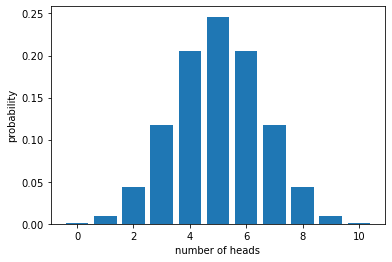

In [12]:
probs = [binomial_prob(x,10,0.5) for x in range(11)]
plt.bar(list(range(11)),probs)
plt.xlabel("number of heads")
plt.ylabel("probability")

playing with this sort of function is a great way to get intuition into a statistical problem. 


**Exercise:** change the value of $p$ and rerun the code above. Does it make sense to you how the distribution is changing shape? Ask youself, what does this mean about data that I would observe.

### Estimation
Next let's turn our attention to estimation of the parameters of our model. In this case our model has a single parameter-- $p$ the probability of heads. The rest of the model is fixed-- $n$ is the number of flips i.e., the experimental design, and $k$ is my data, my actual observation. 

In the Maximum Likelihood world I will seek the value of my parameters that maximize the probability of my data. So in that case I want to find the value of $p$ that leads to the maximum value of the function above, given my data. Let's assume you've flipped the coin a bit more and now $n=240$ flips and let's say you've seen $k=34$ heads. Let's seek the ML estimate of $p$.

One way to do this would be to plug in multiple values of the parameter to our likelihood function and compare probabilities. This is rather brute force but let's try it

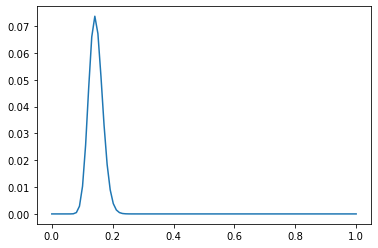

In [13]:
data = 34
n = 240

p_guesses = np.linspace(0,1,100)
lik_p = np.zeros(len(p_guesses))
for i,p in enumerate(p_guesses):
    lik_p[i] = binomial_prob(data, n, p)

plt.plot(p_guesses, lik_p)

In [14]:
from scipy import optimize

data = 34
n = 240

# set up a quick new function based on our old one
# using a lambda function
# the -1 here is because scipy 
# does minimization not max
x = lambda p : -1 * binomial_prob(data, n, p)
res = optimize.minimize_scalar(x, bounds=[0,1], method='bounded')
print(res)

     fun: -0.0736636633198153
 message: 'Solution found.'
    nfev: 12
  status: 0
 success: True
       x: 0.1416666423333202


this little bit of code above is running _optimization_ for us. it is automatically finding the value of $p$ that leads to the highest likelihood of our dataset.

i'm going to package this up into a small function below for you to play with

In [15]:
from scipy import optimize

def estimate_binomial_p(data, n):
    """
    estimates p from binomial
    
    counts data the hard way
    """
    if data > n:
        print("error, counts > n\n")
        return(np.nan)
    
    x = lambda p : -1 * binomial_prob(data, n, p)
    res = optimize.minimize_scalar(x, bounds=[0,1], method='bounded')
    return(res.x)

estimate_binomial_p(9, 10)

0.9000011360345835

**Exercise:** play with the `estimate_binomial_p()` function above by trying out different input numbers. Do the results square with your intuition into the problem

# Maxmimum Likelihood Phylogenetics
Now that we've covered a bit of ML estimation, let's try applying it to our problem-- tree estimation. Again, stated in the business of statistics, our goal is to maximize the probability of our data (i.e. our sequence alignment) give our model (our tree and mutational model).

Rather than do these calculations ourselves we will rely on an external package to calculate tree likelihoods and search for the best possible tree (a very hard problem). The package we will use is called `RAxML` and it's [documentation can be found here](https://cme.h-its.org/exelixis/web/software/raxml/index.html). 

Using this software from within python is a snap. As before we will use biopython for dealing with sequence data and then we will define a RAxML command to run. I'm going to do this on a newer, geographically diverse set of SARS-CoV-2 genome sequences that I have aligned for us in a new file called `data/sc_2_subset.align.fasta`

In [29]:
import os

#define the command line to run
raxml_cline = "raxmlHPC -m GTRCAT -n out -p 10000 --silent --JC69 -s data/sc2_subset.align.fasta > /dev/null"
print("command line: "+raxml_cline)

#a function to get likelihood results
def get_lik(file):
    # get likelihood
    with open(file, "r") as f:
        for line in f:
            tok = line.split()
            if len(tok) > 0 and tok[0] == 'Final':
                lik = float(tok[-1])
    return(lik)

# clean out previous results
if os.path.exists("RAxML_info.out"):
    [os.remove(x) for x in os.listdir(".") if 'RAxML' in x]    

# now run raxml using os.system
os.system(raxml_cline)
best_tree = Phylo.read("RAxML_bestTree.out", "newick")
lik = get_lik("RAxML_info.out")
print(lik)

command line: raxmlHPC -m GTRCAT -n out -p 10000 --silent --JC69 -s data/sc2_subset.align.fasta > /dev/null
-43057.731803


now let's draw that best tree!

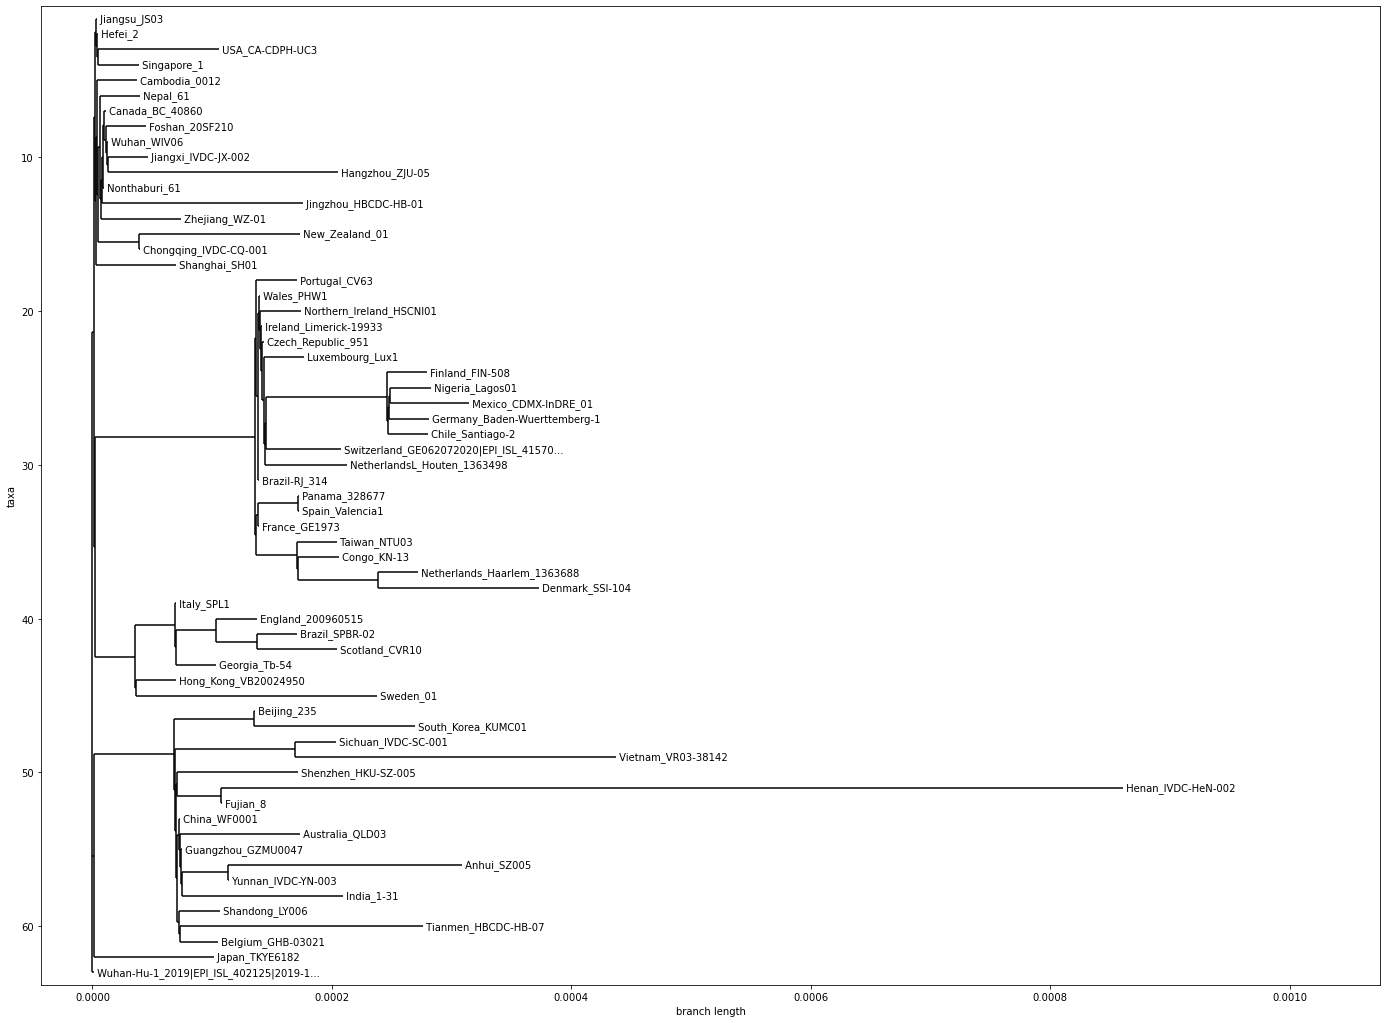

In [17]:
fig,ax = plt.subplots(figsize=[24,18])
Phylo.draw(best_tree,axes=ax)

a bit ugly, so we will probably need to do some tinkering if we want that tree to look nice. but let's focus on likelihoods for minute.

## Comparing likelihoods
One super cool thing about likelihood estimation is we can compare model fits directly by examining the likelihood of our data. let's now compare some different mutational models and look at their likelihoods. We will iterate through these models in order of increasing complexity. Recall this figure from lecture
<img src=imgs/mutation_models.png>

In [30]:
for m in ["JC69", "K80", "HKY85"]:
    raxml_cline = f"raxmlHPC -m GTRCAT -n out -p 10000 --{m} --silent -s data/sc2_subset.align.fasta > /dev/null"
    print("command line: "+raxml_cline)
    # clean out previous results
    if os.path.exists("RAxML_bestTree.out"):
        [os.remove(x) for x in os.listdir(".") if 'RAxML' in x]    

    # now run raxml using os.system
    os.system(raxml_cline)
    lik = get_lik("RAxML_info.out")
    print(f"likelihood of model {m}: {lik}")
    
#now try GTR model
raxml_cline = f"raxmlHPC -m GTRCAT -n out -p 10000 --silent -s data/sc2_subset.align.fasta > /dev/null"
print("command line: "+raxml_cline)
# clean out previous results
if os.path.exists("RAxML_bestTree.out"):
    [os.remove(x) for x in os.listdir(".") if 'RAxML' in x]    

# now run raxml using os.system
os.system(raxml_cline)
lik = get_lik("RAxML_info.out")
print(f"likelihood of model GTR: {lik}")

command line: raxmlHPC -m GTRCAT -n out -p 10000 --JC69 --silent -s data/sc2_subset.align.fasta > /dev/null
likelihood of model JC69: -43057.731803
command line: raxmlHPC -m GTRCAT -n out -p 10000 --K80 --silent -s data/sc2_subset.align.fasta > /dev/null
likelihood of model K80: -43017.176695
command line: raxmlHPC -m GTRCAT -n out -p 10000 --HKY85 --silent -s data/sc2_subset.align.fasta > /dev/null
likelihood of model HKY85: -42112.246428
command line: raxmlHPC -m GTRCAT -n out -p 10000 --silent -s data/sc2_subset.align.fasta > /dev/null
likelihood of model GTR: -42103.229914


so the GTR model has the highest likelihood of these comparisons, but does it fit significantly better than say the HKY85 model? Well to compare these we might consider the number of parameters-- models with more parameters are always able to fit data better because there are more knobs to tweak-- what we call degrees of freedom in the business. 

ML estimates can be compared using a _likelihood ratio_. That is the ratio of the likelihoods of the two models, call them $L_1(\theta)$ and $L_2(\theta)$, can be used to create a test statistic such that
\begin{equation*}
\lambda = -2 \ln \frac{L_1(\theta)}{L_2(\theta)}
\end{equation*}

where \lambda follows a $\chi^2$ distribution with number of degrees of freedom equal to the difference in free parameters between models. If we were to compare the GTR and the HKY85 model we would get
\begin{equation*}
\lambda = -2[-42112.246428 - -42103.229914 ] = 18.033
\end{equation*}

in this case the $\chi^2$ distribution with 4 degrees of freedom has a critical value of ~11 at the upper 2.5% tail, so this difference is significant and we say that the GTR model fits better.

## Using PAML for phylogenetics
For a number of you in here phylogenetics will be one of your common use points for computational biology. biopython has all these neat built ins that help you do things efficiently, without having to reinvent the wheel. 

Among these there exists a nice interface with the popular PAML software package. PAML allows us to perform maximum likelihood phylogenetic estimation in a flexible way. The reason it is so popular though is that it implements a number of tests for positive selection using comparisons of the rate of substitution between synonymous sites ($dS$) and nonsynonymous sites ($dN$). Briefly PAML can estimate the ratio of substitutions rates $\omega = dN / dS$. If all mutations had no effect on fitness than we should expect these rates to be equivalent and $\omega = 1$. If however most mutations at nonsynonymous sites were harmful and thus deleterious to the fitness of the organism, we would expect $\omega < 1$. If on the other nonsynonymous mutations were beneficial on average we could expect $\omega > 1$.

Let's use PAML quickly to play with these ideas.

In [19]:
from Bio.Phylo.PAML import codeml
cml = codeml.Codeml(alignment = "data/lysozymeSmall.txt", tree = "data/lysozymeSmall.trees",
                    out_file = "results.out", working_dir = ".")


In [20]:
#set some PAML options
#can set them manually
cml.set_options(noisy=9,verbose=1,runmode=0,seqtype=1,model=0)
#or with a control file
#cml.read_ctl_file("data/lysozymeSmall.ctl")
cml.print_options()

noisy = 9
verbose = 1
runmode = 0
seqtype = 1
CodonFreq = None
ndata = None
clock = None
aaDist = None
aaRatefile = None
model = 0
NSsites = None
icode = None
Mgene = None
fix_kappa = None
kappa = None
fix_omega = None
omega = None
fix_alpha = None
alpha = None
Malpha = None
ncatG = None
getSE = None
RateAncestor = None
Small_Diff = None
cleandata = None
fix_blength = None
method = None
rho = None
fix_rho = None


great that's our run options. we can then run it simply using the biopython interface

In [21]:
result_dict=cml.run()


and our data will comeback as a dictionary that we can look at

In [22]:
for k in result_dict.keys():
    print(k)
print()    
print(result_dict['model'])

version
model
codon model
NSsites

One dN/dS ratio for branches, 


here are the slots in the dictionary

In [23]:
print(list(result_dict['NSsites'][0].keys()))
#print(list(result_dict['NSsites'][0]['parameters']['omega']))


['description', 'lnL', 'tree length', 'tree', 'parameters']


## comparing models using PAML
Let's compare so called Model 0, which has one dN/dS ratio along the tree, with Model 1 which allows for different rates along each branch

In [24]:
from Bio import Phylo

for i in range(2):
    cml.set_options(noisy=9,verbose=1,runmode=0,seqtype=1,model=i)
    result_dict=cml.run()
    print(f"model {i} -- {result_dict['model']} lnL: {result_dict['NSsites'][0]['lnL']}")


model 0 -- One dN/dS ratio for branches,  lnL: -920.930308
model 1 -- free dN/dS Ratios for branches for branches,  lnL: -911.963802


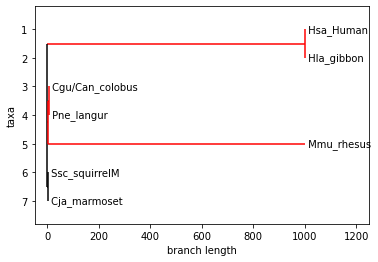

In [25]:
# easy to get labelled trees from PAML output file called mlc

fh = open("mlc","r")
lines = fh.readlines()
omega_tree = lines[-4].replace(" #",":")

# we can plot the tree
from io import StringIO
tree = Phylo.read(StringIO(omega_tree), "newick")
  
for c in tree.find_clades():
    if c.branch_length != None and  c.branch_length > 1:
        c.color = 'red'
  
Phylo.draw(tree)

In [26]:
print(tree)

Tree(rooted=False, weight=1.0)
    Clade()
        Clade(branch_length=999.0)
            Clade(branch_length=0.718297, name='Hsa_Human')
            Clade(branch_length=0.251881, name='Hla_gibbon')
        Clade(branch_length=1.50409)
            Clade(branch_length=3.5119)
                Clade(branch_length=0.65113, name='Cgu/Can_colobus')
                Clade(branch_length=0.872451, name='Pne_langur')
            Clade(branch_length=999.0, name='Mmu_rhesus')
        Clade(branch_length=0.491667)
            Clade(branch_length=0.560492, name='Ssc_squirrelM')
            Clade(branch_length=0.0001, name='Cja_marmoset')
